In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from torch.autograd import Variable

data = np.genfromtxt('/content/Biomarker_Clinical_Data_Images.csv', delimiter=',', skip_header=1, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))

with_headers = np.genfromtxt('/content/Biomarker_Clinical_Data_Images.csv', delimiter=',', names=True, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))

avgArr = np.zeros([int(data.shape[0]/49), data.shape[1]])

for i in range(0, int(data.shape[0]/49)):
  start = 49*i+1
  scans = data[start:start+48,:]
  avgArr[i] = scans.mean(axis=0)

np.set_printoptions(precision=3, suppress=True)

presence = np.ceil(avgArr)

biomarkerAvg, temp = np.hsplit(avgArr, np.array([16]))
__, scores = np.hsplit(temp, np.array([1]))
biomarkerPresence, __ = np.hsplit(presence, np.array([16]))

avg_train, avg_test, score_train, score_test = train_test_split(biomarkerAvg, scores, train_size = 150, test_size=42, random_state=0)
presence_train, presence_test, __, __ = train_test_split(biomarkerPresence, scores, train_size = 150, test_size=42, random_state=0)

score_train = (score_train - score_train.min(0))/score_train.ptp(0)
score_test = (score_test - score_test.min(0))/score_test.ptp(0)

np.savetxt('presence.csv', presence, delimiter=',')
np.savetxt('average.csv', avgArr, delimiter=',')
np.savetxt('scores.csv', scores, delimiter=',')


In [2]:
torch_avg_train = Variable(torch.from_numpy(avg_train).float())
torch_avg_test = Variable(torch.from_numpy(avg_test).float())
torch_presence_train = Variable(torch.from_numpy(presence_train).float())
torch_presence_test = Variable(torch.from_numpy(presence_test).float())
torch_score_train = Variable(torch.from_numpy(score_train).float())
torch_score_test = Variable(torch.from_numpy(score_test).float())

class FullLinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(FullLinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 4)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4, 16)
        self.sig = torch.nn.Sigmoid()
    def forward(self, x):
        X = self.linear(x)
        X2 = self.relu(X)
        X3 = self.linear2(X2)
        y_pred = self.sig(X3)
        return y_pred

In [3]:
class SingleLinearRegressionModel(torch.nn.Module):
    def __init__(self):
        super(SingleLinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(2, 4)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4, 1)
        self.sig = torch.nn.Sigmoid()
    def forward(self, x):
        X = self.linear(x)
        X2 = self.relu(X)
        X3 = self.linear2(X2)
        y_pred = self.sig(X3)
        return y_pred

In [40]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

try:
  del avgModel
  del presenceModel
  del loss_fn
  del avg_optimizer
  del presence_optimizer
except:
  pass

presenceModel = FullLinearRegressionModel()
avgModel = FullLinearRegressionModel()
loss_fn_presence = torch.nn.BCELoss()
loss_fn_avg = torch.nn.MSELoss()
avg_optimizer = torch.optim.Adam(avgModel.parameters(), lr = 0.01)
presence_optimizer = torch.optim.Adam(presenceModel.parameters(), lr = 0.01)

biomarkerNames = []
acc_arr = []
pLoss = []
aLoss = []

acc_arr0 = np.zeros(16)
acc_arr1 = np.zeros(16)

for epoch in range(5000):

    presenceModel.train()
    avgModel.train()

    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y_presence = presenceModel(torch_score_train)
    pred_y_avg = avgModel(torch_score_train)

    #pred_y_presence = (pred_y_presence > 0.5).float()
    #pred_y_presence = Variable(pred_y_presence, requires_grad = True)

    # Compute and print loss
    loss_presence = loss_fn_presence(pred_y_presence, torch_presence_train)
    loss_avg = loss_fn_avg(pred_y_avg, torch_avg_train)

    # Zero gradients, perform a backward pass,
    # and update the weights.
    avg_optimizer.zero_grad()
    presence_optimizer.zero_grad()

    loss_presence.backward()
    loss_avg.backward()

    avg_optimizer.step()
    presence_optimizer.step()

    #if (epoch % 20 == 0):
    #  print('epoch {:04}: loss (average):  {}'.format(epoch, loss_avg.item()))
    #  print('            loss (presence): {}'.format(loss_presence.item()))

presenceModel.eval()
avgModel.eval()
test_pred_avg = avgModel(torch_score_test)
test_pred_presence = presenceModel(torch_score_test)
test_pred_presence = test_pred_presence > 0.5
np.set_printoptions(precision=3, suppress=True)
torch.set_printoptions(threshold=10_000)
#print(test_pred_avg)
#print(test_pred_presence)

for i in range(0,16):
  biomarkerNames.append(with_headers.dtype.names[i])
  acc = accuracy_score(torch_presence_test[:,i], test_pred_presence[:,i])
  acc_arr.append(acc)
  #print(test_pred_presence[:,i].dtype)
  #print(torch_presence_test[:,i].dtype)
  pLoss.append(loss_fn_presence(test_pred_presence[:,i].float(), torch_presence_test[:,i]).item())
  aLoss.append(loss_fn_avg(test_pred_avg[:,i], torch_avg_test[:,i]).item())
  print(f"{with_headers.dtype.names[i]} ({i+1}):")
  print("  Presence:")
  print(f"    Accuracy: {acc}")
  print(f"    Loss: {pLoss[i]}")
  print("  Average:")
  print(f"    Loss: {aLoss[i]}")

  print("\nClassification Report - Breakdown by Positive/Negative Classification")
  report = classification_report(torch_presence_test[:,i], test_pred_presence[:,i], zero_division=0)
  print(f"\n{report}")

  for class_name, metrics in classification_report(torch_presence_test[:,i], test_pred_presence[:,i], zero_division=0, output_dict=True).items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        if class_name == "0.0":
          acc_arr0[i] = (metrics['recall'])
        else:
          acc_arr1[i] = (metrics['recall'])

  print("\n")

print("Full classification report based on presence:")
report = classification_report(torch_presence_test, test_pred_presence, zero_division=0)
print(report)

Atrophy__thinning_of_retinal_layers (1):
  Presence:
    Accuracy: 0.9047619047619048
    Loss: 9.523809432983398
  Average:
    Loss: 0.024705756455659866

Classification Report - Breakdown by Positive/Negative Classification

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        38
         1.0       0.00      0.00      0.00         4

    accuracy                           0.90        42
   macro avg       0.45      0.50      0.47        42
weighted avg       0.82      0.90      0.86        42



Disruption_of_EZ (2):
  Presence:
    Accuracy: 0.6666666666666666
    Loss: 33.33333206176758
  Average:
    Loss: 0.01478827279061079

Classification Report - Breakdown by Positive/Negative Classification

              precision    recall  f1-score   support

         0.0       0.78      0.78      0.78        32
         1.0       0.30      0.30      0.30        10

    accuracy                           0.67        42
   macro avg     

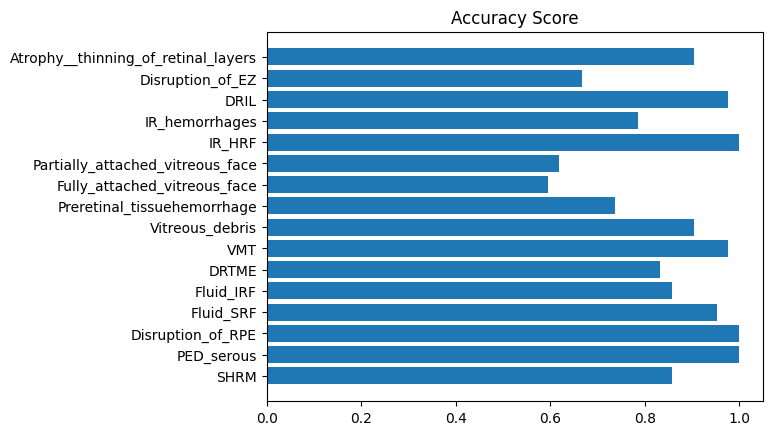

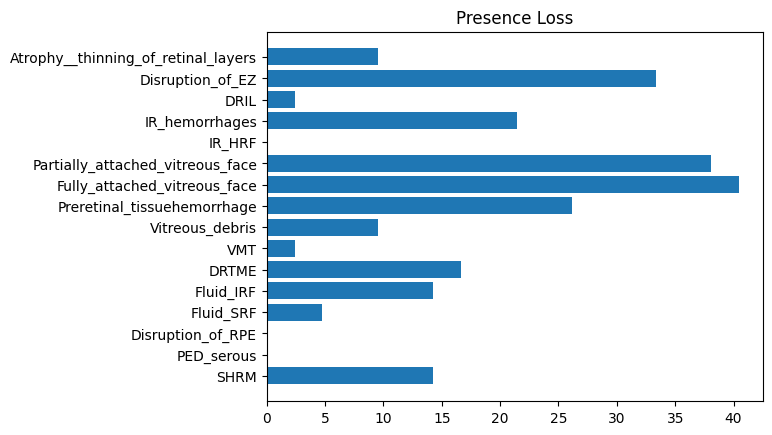

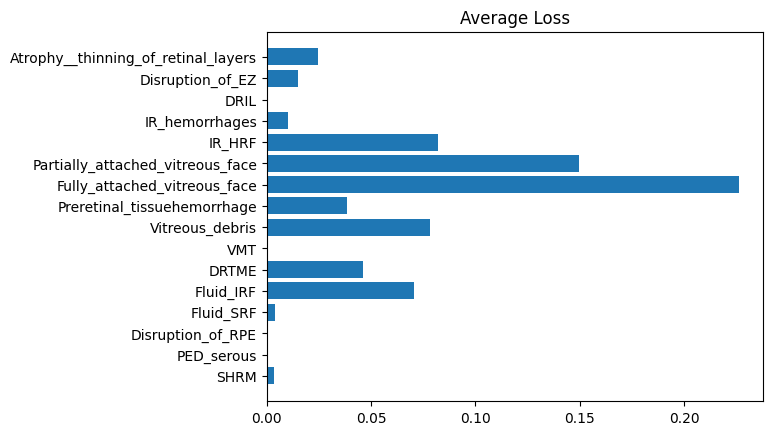

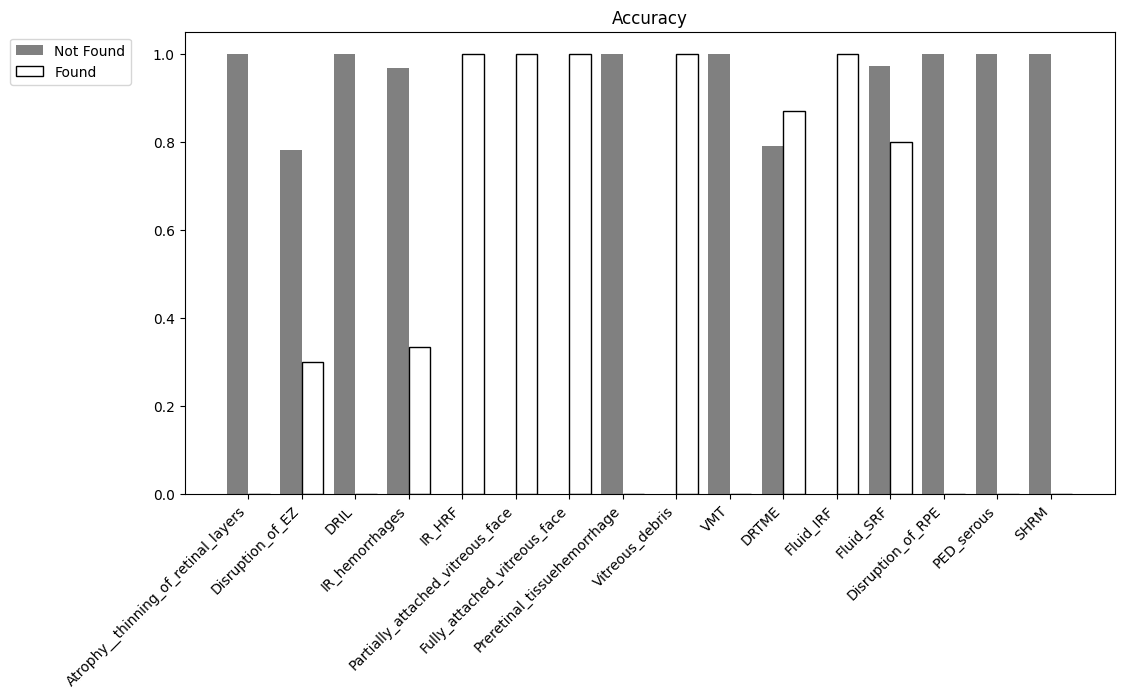

In [41]:
plt.barh(biomarkerNames, acc_arr)
plt.gca().invert_yaxis()
plt.title('Accuracy Score')
plt.show()

plt.barh(biomarkerNames, pLoss)
plt.gca().invert_yaxis()
plt.title('Presence Loss')
plt.show()

plt.barh(biomarkerNames, aLoss)
plt.gca().invert_yaxis()
plt.title('Average Loss')
plt.show()

plt.figure(figsize=(12, 6))

X_axis = np.arange(len(biomarkerNames))

plt.bar(X_axis - 0.2, acc_arr0, 0.4, label = 'Not Found', color='grey')
plt.bar(X_axis + 0.2, acc_arr1, 0.4, label = 'Found', color='white', edgecolor='black', linewidth=1)

plt.xticks(X_axis, biomarkerNames, rotation=45, ha="right")
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(-0.05, 1), loc='upper right')
plt.show()

In [34]:
try:
  del singleModel
except:
  pass

biomarkerNames = []
acc_arr = []
pLoss = []
aLoss = []

acc_arr0 = np.zeros(16)
acc_arr1 = np.zeros(16)

for i in range(0,16):
  try:
    del singleModel
    del loss_fn
    del optimizer
  except:
    pass

  biomarkerNames.append(with_headers.dtype.names[i])

  singlePresence = biomarkerPresence[:,i].reshape(-1,1)
  singleAvg = biomarkerAvg[:,i].reshape(-1,1)

  single_presence_train, single_presence_test, __, __ = train_test_split(singlePresence, scores, train_size = 150, test_size=42, random_state=0)
  single_avg_train, single_avg_test, __, __ = train_test_split(singleAvg, scores, train_size = 150, test_size=42, random_state=0)

  torch_single_presence_train = Variable(torch.from_numpy(single_presence_train).float())
  torch_single_presence_test = Variable(torch.from_numpy(single_presence_test).float())
  torch_single_avg_train = Variable(torch.from_numpy(single_avg_train).float())
  torch_single_avg_test = Variable(torch.from_numpy(single_avg_test).float())

  singleModel = SingleLinearRegressionModel()
  loss_fn = torch.nn.BCELoss()
  optimizer = torch.optim.Adam(singleModel.parameters(), lr = 0.01)
  for epoch in range(5000):
    pred_y = singleModel(torch_score_train)
    #pred_y = (pred_y > 0.5).float()
    #pred_y = Variable(pred_y, requires_grad = True)
    loss = loss_fn(pred_y, torch_single_presence_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #if (epoch == 998):
    #  print(pred_y)
  bin_pred = singleModel(torch_score_test)
  bin_pred = (bin_pred > 0.5).float()
  #bin_pred = Variable(bin_pred, requires_grad = True)
  loss = loss_fn(bin_pred, torch_single_presence_test)
  acc = accuracy_score(torch_single_presence_test, bin_pred)

  acc_arr.append(acc)
  pLoss.append(loss.item())

  report = classification_report(torch_single_presence_test, bin_pred, zero_division=0)

  print(f"{with_headers.dtype.names[i]} ({i+1}):")
  print("  Presence:")
  print(f"    Accuracy: {acc}")
  print(f"    Loss: {loss.item()}")

  del singleModel
  del loss_fn
  del optimizer
  singleModel = SingleLinearRegressionModel()
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(singleModel.parameters(), lr = 0.01)

  for epoch in range(5000):
    pred_y = singleModel(torch_score_train)
    loss = loss_fn(pred_y, (torch_single_avg_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  pred = singleModel(torch_score_test)
  loss = loss_fn(pred, (torch_single_avg_test))

  aLoss.append(loss.item())

  print("  Average:")
  print(f"    Loss: {loss.item()}\n")

  print("Classification Beport - Breakdown by Positive/Negative Classification")
  print(report)
  print("\n")

  for class_name, metrics in classification_report(torch_single_presence_test, bin_pred, zero_division=0, output_dict=True).items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
      if class_name == "0.0":
        acc_arr0[i] = (metrics['recall'])
      else:
        acc_arr1[i] = (metrics['recall'])



Atrophy__thinning_of_retinal_layers (1):
  Presence:
    Accuracy: 0.9047619047619048
    Loss: 9.523809432983398
  Average:
    Loss: 0.02446208894252777

Classification Beport - Breakdown by Positive/Negative Classification
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95        38
         1.0       0.00      0.00      0.00         4

    accuracy                           0.90        42
   macro avg       0.45      0.50      0.47        42
weighted avg       0.82      0.90      0.86        42



Disruption_of_EZ (2):
  Presence:
    Accuracy: 0.6190476190476191
    Loss: 38.095237731933594
  Average:
    Loss: 0.01748916320502758

Classification Beport - Breakdown by Positive/Negative Classification
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.74        32
         1.0       0.25      0.30      0.27        10

    accuracy                           0.62        42
   macro avg       

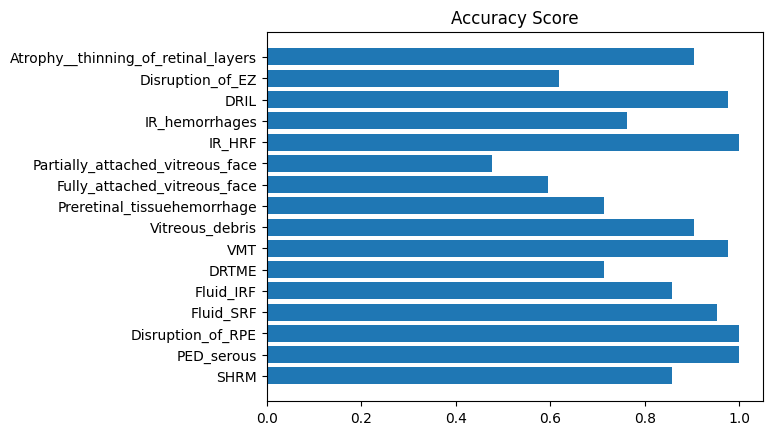

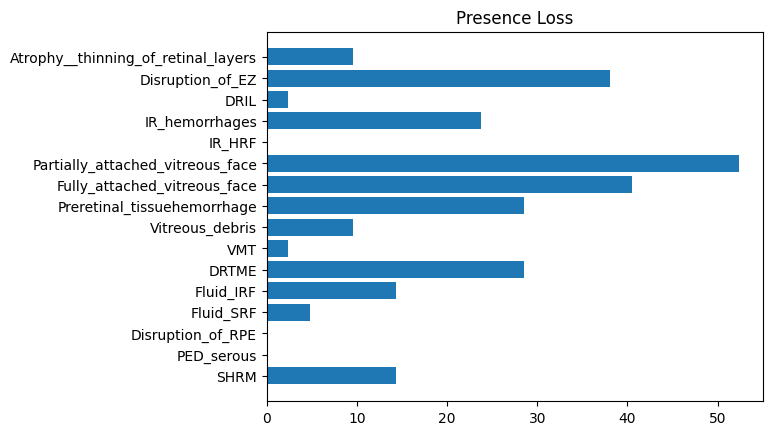

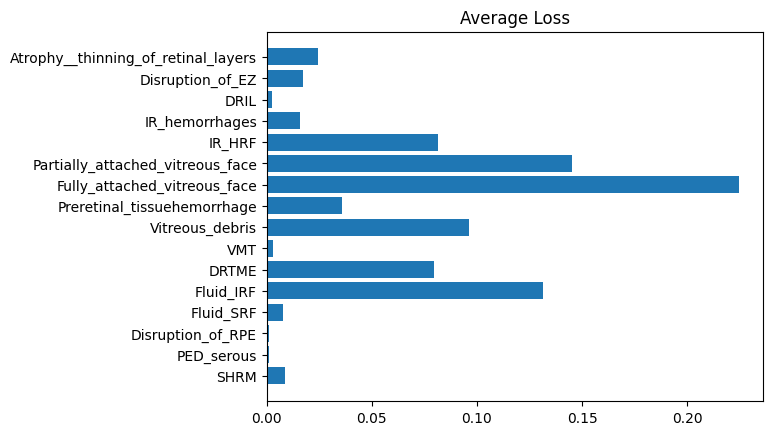

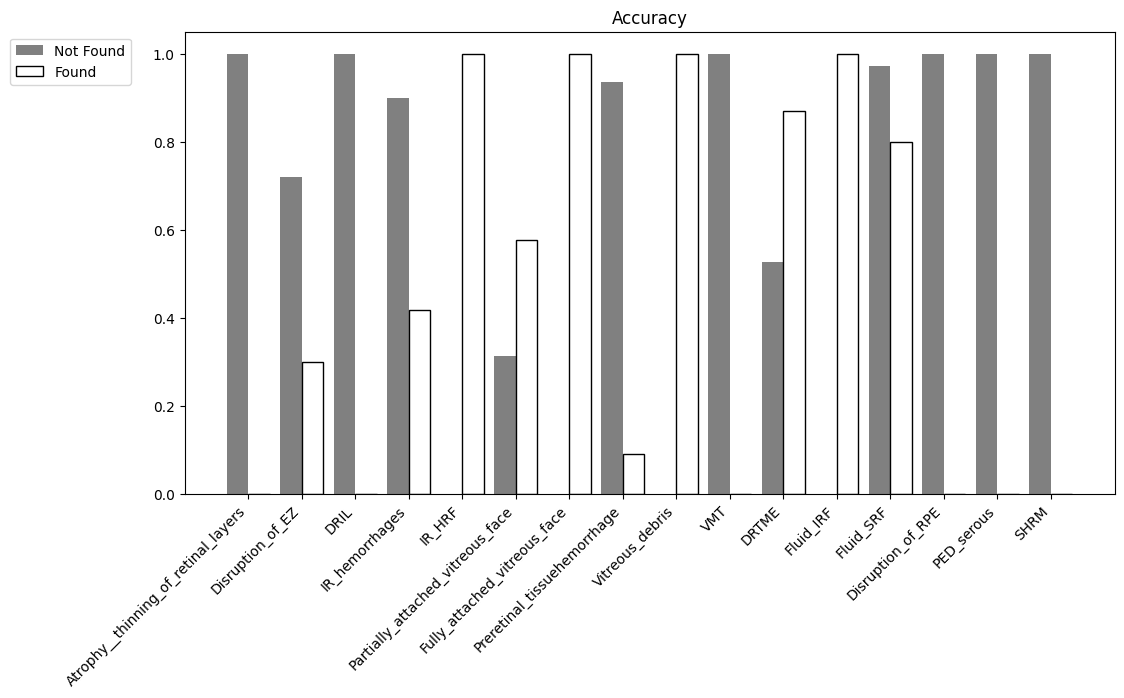

In [39]:
plt.barh(biomarkerNames, acc_arr)
plt.gca().invert_yaxis()
plt.title('Accuracy Score')
plt.show()

plt.barh(biomarkerNames, pLoss)
plt.gca().invert_yaxis()
plt.title('Presence Loss')
plt.show()

plt.barh(biomarkerNames, aLoss)
plt.gca().invert_yaxis()
plt.title('Average Loss')
plt.show()

plt.figure(figsize=(12, 6))

X_axis = np.arange(len(biomarkerNames))

plt.bar(X_axis - 0.2, acc_arr0, 0.4, label = 'Not Found', color='grey')
plt.bar(X_axis + 0.2, acc_arr1, 0.4, label = 'Found', color='white', edgecolor='black', linewidth=1)

plt.xticks(X_axis, biomarkerNames, rotation=45, ha="right")
plt.title("Accuracy")
plt.legend(bbox_to_anchor=(-0.05, 1), loc='upper right')
plt.show()